In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/Colab Notebooks/speech_data.zip"

In [2]:
commands_train_dir='speech_data/commands/train/'
commands_test_dir='speech_data/commands/test/'

digits_train_dir='speech_data/digits/train/'
digits_test_dir='speech_data/digits/test/'

In [76]:
import numpy as np
import os
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_graph(filename,name=''):
    """Unpersists graph from file as default graph."""
    with tf.gfile.FastGFile(filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name=name)
    return graph_def

def run_graph(sess,output_tensor,wav_file):
    with open(wav_file, 'rb') as wav_file:
        wav_data = wav_file.read()
    input_layer_name = 'wav_data:0'
    predictions, = sess.run(output_tensor, {input_layer_name: wav_data})
    return predictions        

def is_wav(path):
    _, file_extension = os.path.splitext(path)
    return file_extension.lower() in ['.wav']

# Commands & conv_actions_frozen.pb

In [20]:
tf.reset_default_graph()
graph_def=load_graph('speech_data/conv_actions_frozen.pb')
print([n.name for n in graph_def.node])

['wav_data', 'decoded_sample_data', 'AudioSpectrogram', 'Mfcc', 'Reshape/shape', 'Reshape', 'Variable', 'Variable/read', 'Variable_1', 'Variable_1/read', 'Conv2D', 'add', 'Relu', 'MaxPool', 'Variable_2', 'Variable_2/read', 'Variable_3', 'Variable_3/read', 'Conv2D_1', 'add_1', 'Relu_1', 'Reshape_1/shape', 'Reshape_1', 'Variable_4', 'Variable_4/read', 'Variable_5', 'Variable_5/read', 'MatMul', 'add_2', 'labels_softmax']


In [106]:
X_train_1 = np.empty([0, 64000])
X_test_1 = np.empty([0, 64000])

y_train_1 = np.empty(0)
y_test_1 = np.empty(0)

#Command recognition
command_labels=['_silence_','_unknown_','yes','no','up','down','left','right','on','off','stop','go']
with tf.Session() as sess:
    out_tensor = sess.graph.get_tensor_by_name('Reshape_1:0')
    
    for d in next(os.walk(commands_test_dir))[1]:
        for f in next(os.walk(os.path.join(commands_test_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(commands_test_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_test_1 = np.vstack([X_test_1, np.array(preds)])
                y_test_1 = np.append(y_test_1, command_labels.index(d))
                
    for d in next(os.walk(commands_train_dir))[1]:
        for f in next(os.walk(os.path.join(commands_train_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(commands_train_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_train_1 = np.vstack([X_train_1, np.array(preds)])
                y_train_1 = np.append(y_train_1, command_labels.index(d))

In [70]:
X_train_1.shape

(100, 64000)

## kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_1, y_train_1)

y_train_predict = knn.predict(X_train_1)
y_test_predict = knn.predict(X_test_1)

err_train = np.mean(y_train_1 != y_train_predict)
err_test  = np.mean(y_test_1  != y_test_predict)

print(err_train, err_test)

0.0 0.17346938775510204


In [83]:
k_ = np.arange(1,99,10)
k_

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [84]:
test_err = []
train_err = []
for k in k_:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_1, y_train_1)

    y_train_pred = knn.predict(X_train_1)
    y_test_pred = knn.predict(X_test_1)
    train_err.append(np.mean(y_train_1 != y_train_pred))
    test_err.append(np.mean(y_test_1 != y_test_pred))

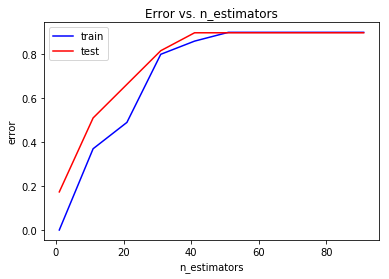

In [85]:
plt.plot(k_, train_err, 'b', label = 'train')
plt.plot(k_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [86]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = range_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = range_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.17346938775510204
Best 'n_estimators' for Test:  [1]
Best 'n_estimators' for Train:  [1]


# SVM

In [105]:
from sklearn.svm import SVC
svc = SVC(C=0.1, kernel='linear')
svc.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != svc.predict(X_train_1))
err_test  = np.mean(y_test_1 != svc.predict(X_test_1))

print(err_train, err_test)

0.0 0.15306122448979592


# Tree

In [67]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != rf.predict(X_train_1))
err_test  = np.mean(y_test_1  != rf.predict(X_test_1))

print(err_train, err_test)

0.0 0.32653061224489793


In [69]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 1000).fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != ert.predict(X_train_1))
err_test  = np.mean(y_test_1  != ert.predict(X_test_1))

print(err_train, err_test)

0.0 0.2755102040816326


# Digits

In [111]:
X_train_1 = np.empty([0, 64000])
X_test_1 = np.empty([0, 64000])

y_train_1 = np.empty(0)
y_test_1 = np.empty(0)

#Command recognition
command_labels=['zero','one','two','three','four','five','six','seven','eight','nine']
with tf.Session() as sess:
    out_tensor = sess.graph.get_tensor_by_name('Reshape_1:0')
    
    for d in next(os.walk(digits_test_dir))[1]:
        for f in next(os.walk(os.path.join(digits_test_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(digits_test_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_test_1 = np.vstack([X_test_1, np.array(preds)])
                y_test_1 = np.append(y_test_1, command_labels.index(d))
                
    for d in next(os.walk(digits_train_dir))[1]:
        for f in next(os.walk(os.path.join(digits_train_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(digits_train_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_train_1 = np.vstack([X_train_1, np.array(preds)])
                y_train_1 = np.append(y_train_1, command_labels.index(d))

# kNN

In [115]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_1, y_train_1)

y_train_predict = knn.predict(X_train_1)
y_test_predict = knn.predict(X_test_1)

err_train = np.mean(y_train_1 != y_train_predict)
err_test  = np.mean(y_test_1  != y_test_predict)

print(err_train, err_test)

0.0 0.22772277227722773


In [120]:
k_ = np.arange(1,60,10)
k_

array([ 1, 11, 21, 31, 41, 51])

In [121]:
test_err = []
train_err = []
for k in k_:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_1, y_train_1)

    y_train_pred = knn.predict(X_train_1)
    y_test_pred = knn.predict(X_test_1)
    train_err.append(np.mean(y_train_1 != y_train_pred))
    test_err.append(np.mean(y_test_1 != y_test_pred))

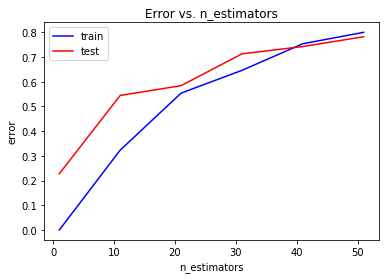

In [122]:
plt.plot(k_, train_err, 'b', label = 'train')
plt.plot(k_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [124]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = k_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = k_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.22772277227722773
Best 'n_estimators' for Test:  [1]
Best 'n_estimators' for Train:  [1]


# SVC

In [128]:
from sklearn.svm import SVC
svc = SVC(C=1, kernel='linear')
svc.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != svc.predict(X_train_1))
err_test  = np.mean(y_test_1 != svc.predict(X_test_1))

print(err_train, err_test)

0.0 0.2376237623762376


# Tree

In [133]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 2000)
rf.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != rf.predict(X_train_1))
err_test  = np.mean(y_test_1  != rf.predict(X_test_1))

print(err_train, err_test)

0.0 0.38613861386138615


In [135]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 2000).fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != ert.predict(X_train_1))
err_test  = np.mean(y_test_1  != ert.predict(X_test_1))

print(err_train, err_test)

0.0 0.37623762376237624


In [ ]:
tf.reset_default_graph()
graph_def=load_graph('speech_data/lo')
print([n.name for n in graph_def.node])

# low_latency_svdf.pb

# commands

In [147]:
tf.reset_default_graph()
graph_def=load_graph('speech_data/low_latency_svdf.pb')
print([n.name for n in graph_def.node])

['wav_data', 'decoded_sample_data', 'AudioSpectrogram', 'Mfcc/sample_rate', 'Mfcc', 'Reshape/shape', 'Reshape', 'runtime-memory', 'runtime-memory/read', 'count_nonzero/zeros', 'count_nonzero/NotEqual', 'count_nonzero/ToInt64', 'count_nonzero/Const', 'count_nonzero/Sum', 'Equal/y', 'Equal', 'cond/Switch', 'cond/switch_t', 'cond/switch_f', 'cond/Const', 'cond/Const_1', 'cond/Merge', 'Neg', 'mul/y', 'mul', 'strided_slice/stack/0', 'strided_slice/stack', 'strided_slice/stack_1', 'strided_slice/stack_2', 'strided_slice', 'ExpandDims/dim', 'ExpandDims', 'weights_frequency', 'weights_frequency/read', 'ExpandDims_1/dim', 'ExpandDims_1', 'conv1d/ExpandDims/dim', 'conv1d/ExpandDims', 'conv1d/ExpandDims_1/dim', 'conv1d/ExpandDims_1', 'conv1d/Conv2D', 'conv1d/Squeeze', 'transpose/perm', 'transpose', 'strided_slice_1/stack/0', 'strided_slice_1/stack/1', 'strided_slice_1/stack', 'strided_slice_1/stack_1', 'strided_slice_1/stack_2', 'strided_slice_1', 'concat/axis', 'concat', 'weights_time', 'weights

In [148]:
with tf.Session() as sess:

    acc=0
    num_tests=0
    for d in next(os.walk(commands_test_dir))[1]:
        for f in next(os.walk(os.path.join(commands_test_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(commands_test_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                print(preds.shape)
                break
                #num_tests+=1
                #if preds.argmax()==command_labels.index(d):
                #    acc+=1
        break
    #print('low_latency_svdf accuracy:',acc/num_tests)


(1280,)


In [150]:
X_train_1 = np.empty([0, 1280])
X_test_1 = np.empty([0, 1280])

y_train_1 = np.empty(0)
y_test_1 = np.empty(0)

#Command recognition
command_labels=['_silence_','_unknown_','yes','no','up','down','left','right','on','off','stop','go']
with tf.Session() as sess:
    out_tensor = sess.graph.get_tensor_by_name('Relu:0')
    
    for d in next(os.walk(commands_test_dir))[1]:
        for f in next(os.walk(os.path.join(commands_test_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(commands_test_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_test_1 = np.vstack([X_test_1, np.array(preds)])
                y_test_1 = np.append(y_test_1, command_labels.index(d))
                
    for d in next(os.walk(commands_train_dir))[1]:
        for f in next(os.walk(os.path.join(commands_train_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(commands_train_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_train_1 = np.vstack([X_train_1, np.array(preds)])
                y_train_1 = np.append(y_train_1, command_labels.index(d))

In [154]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_1, y_train_1)

y_train_predict = knn.predict(X_train_1)
y_test_predict = knn.predict(X_test_1)

err_train = np.mean(y_train_1 != y_train_predict)
err_test  = np.mean(y_test_1  != y_test_predict)

print(err_train, err_test)

0.0 0.24489795918367346


In [155]:
k_ = np.arange(1,60,10)
test_err = []
train_err = []
for k in k_:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_1, y_train_1)

    y_train_pred = knn.predict(X_train_1)
    y_test_pred = knn.predict(X_test_1)
    train_err.append(np.mean(y_train_1 != y_train_pred))
    test_err.append(np.mean(y_test_1 != y_test_pred))

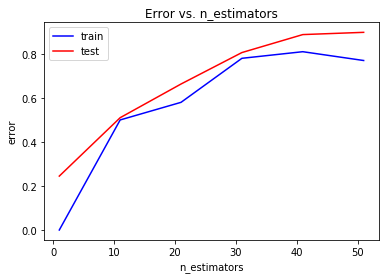

In [156]:
plt.plot(k_, train_err, 'b', label = 'train')
plt.plot(k_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [157]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = k_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = k_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.24489795918367346
Best 'n_estimators' for Test:  [1]
Best 'n_estimators' for Train:  [1]


# SVC

In [158]:
from sklearn.svm import SVC
svc = SVC(C=1, kernel='linear')
svc.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != svc.predict(X_train_1))
err_test  = np.mean(y_test_1 != svc.predict(X_test_1))

print(err_train, err_test)

0.01 0.20408163265306123


# Digits

In [159]:
X_train_1 = np.empty([0, 1280])
X_test_1 = np.empty([0, 1280])

y_train_1 = np.empty(0)
y_test_1 = np.empty(0)

#Command recognition
command_labels=['zero','one','two','three','four','five','six','seven','eight','nine']
with tf.Session() as sess:
    out_tensor = sess.graph.get_tensor_by_name('Relu:0')
    
    for d in next(os.walk(digits_test_dir))[1]:
        for f in next(os.walk(os.path.join(digits_test_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(digits_test_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_test_1 = np.vstack([X_test_1, np.array(preds)])
                y_test_1 = np.append(y_test_1, command_labels.index(d))
                
    for d in next(os.walk(digits_train_dir))[1]:
        for f in next(os.walk(os.path.join(digits_train_dir,d)))[2]:
            if is_wav(f):
                wav_file=os.path.join(digits_train_dir,d,f)        
                preds=run_graph(sess,out_tensor,wav_file)
                X_train_1 = np.vstack([X_train_1, np.array(preds)])
                y_train_1 = np.append(y_train_1, command_labels.index(d))

# kNN

In [160]:
k_ = np.arange(1,60,10)
test_err = []
train_err = []
for k in k_:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_1, y_train_1)

    y_train_pred = knn.predict(X_train_1)
    y_test_pred = knn.predict(X_test_1)
    train_err.append(np.mean(y_train_1 != y_train_pred))
    test_err.append(np.mean(y_test_1 != y_test_pred))

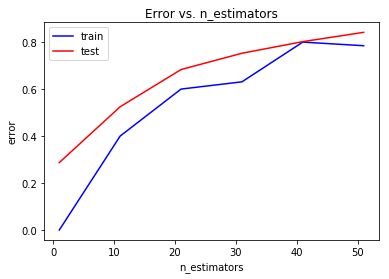

In [161]:
plt.plot(k_, train_err, 'b', label = 'train')
plt.plot(k_, test_err, 'r', label = 'test')
plt.title('Error vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()
pass

In [162]:
print("Минимальная ошибка на тренировочной:", np.min(train_err))
print("Минимальная ошибка на тестовой:", np.min(test_err))
r = k_[test_err == np.min(test_err)]
print("Best 'n_estimators' for Test: ", r)
r = k_[train_err == np.min(train_err)]
print("Best 'n_estimators' for Train: ", r)

Минимальная ошибка на тренировочной: 0.0
Минимальная ошибка на тестовой: 0.2871287128712871
Best 'n_estimators' for Test:  [1]
Best 'n_estimators' for Train:  [1]


# SVC

In [165]:
from sklearn.svm import SVC
svc = SVC(C=10, kernel='linear')
svc.fit(X_train_1, y_train_1)

err_train = np.mean(y_train_1 != svc.predict(X_train_1))
err_test  = np.mean(y_test_1 != svc.predict(X_test_1))

print(err_train, err_test)

0.0 0.2871287128712871
